In [1]:
#!pip3 install --upgrade transformers
!pip install simpletransformers

In [113]:
!pip install textfeatures

In [2]:
#!pip3 install sentencepiece

In [3]:
import pandas as pd
import numpy as np
import sklearn
from tqdm import tqdm, notebook
from tqdm import tqdm
import textfeatures as tf

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:

df = pd.read_csv('twitter_sexism_parsed_dataset.csv',encoding = 'iso-8859-1')#,names=['id', 'text', 'ICD_Chapter', 'label'])
df.head()

,index,id,Text,Annotation,oh_label
0,5.35198627292254E+017,5.35198627292254E+017,RT @BeepsS: @senna1 @BeepsS: I'm not sexist bu...,sexism,1.0
1,5.75984924030714E+017,5.75984924030714E+017,There's some very hate able teams this year #MKR,none,0.0
2,5.7233536016588E+017,5.7233536016588E+017,"RT @The_Eccles: ""Everyone underestimated us"" \...",none,0.0
3,5.72337925708374E+017,5.72337925708374E+017,RT @NOTLukeDarcy: did @Channel7 or #MKR actual...,none,0.0
4,4.43033024528011E+017,4.43033024528011E+017,"No, you don't. @Shut_Up_Jeff: I thought of a r...",sexism,1.0


In [6]:
df.isnull().sum()

index         0
id            1
Text          1
Annotation    3
oh_label      3
dtype: int64

In [7]:
df['Text']=df['Text'].fillna("")


df['oh_label'] = df['oh_label'].fillna(0)

In [8]:
# Removed the stopword
tf.stopwords(df,"Text","stopword")
df[["Text","stopword"]].head()

,Text,stopword
0,RT @BeepsS: @senna1 @BeepsS: I'm not sexist bu...,"[not, but, if, you're, a, and, you, your]"
1,There's some very hate able teams this year #MKR,"[some, very, this]"
2,"RT @The_Eccles: ""Everyone underestimated us"" \...","[as, as, the]"
3,RT @NOTLukeDarcy: did @Channel7 or #MKR actual...,"[did, or, if, any, of, these]"
4,"No, you don't. @Shut_Up_Jeff: I thought of a r...","[you, of, a, and, not, but, have, to]"


In [9]:
tf.clean(df,"Text","CText")
df[["Text","CText"]].head()

,Text,CText
0,RT @BeepsS: @senna1 @BeepsS: I'm not sexist bu...,beepss senna beepss sexist fuck youre woman ca...
1,There's some very hate able teams this year #MKR,theres hate able teams year
2,"RT @The_Eccles: ""Everyone underestimated us"" \...",the_eccles everyone underestimated still well ...
3,RT @NOTLukeDarcy: did @Channel7 or #MKR actual...,notlukedarcy channel actually check people cou...
4,"No, you don't. @Shut_Up_Jeff: I thought of a r...",dont shut_up_jeff thought really funny joke pr...


In [10]:
df.columns

Index(['index', 'id', 'Text', 'Annotation', 'oh_label', 'stopword', 'CText'], dtype='object')

In [11]:
df = df.iloc[:,2:]

In [12]:
df.head()

,Text,Annotation,oh_label,stopword,CText
0,RT @BeepsS: @senna1 @BeepsS: I'm not sexist bu...,sexism,1.0,"[not, but, if, you're, a, and, you, your]",beepss senna beepss sexist fuck youre woman ca...
1,There's some very hate able teams this year #MKR,none,0.0,"[some, very, this]",theres hate able teams year
2,"RT @The_Eccles: ""Everyone underestimated us"" \...",none,0.0,"[as, as, the]",the_eccles everyone underestimated still well ...
3,RT @NOTLukeDarcy: did @Channel7 or #MKR actual...,none,0.0,"[did, or, if, any, of, these]",notlukedarcy channel actually check people cou...
4,"No, you don't. @Shut_Up_Jeff: I thought of a r...",sexism,1.0,"[you, of, a, and, not, but, have, to]",dont shut_up_jeff thought really funny joke pr...


In [13]:
df = df[['CText', 'oh_label']]

In [14]:
df.rename(columns={'CText':'Text','oh_label':'label'}, inplace = True)

In [15]:
df.label = df.label.astype('int64')

In [16]:
df.label = pd.to_numeric(df.label, errors='coerce')
print(df.dtypes)

Text     object
label     int64
dtype: object


In [17]:
df.Text = str(df['Text']).rstrip()


In [18]:
sorted(df.label.unique())
num_labels = df.label.nunique()
num_labels

2

In [19]:
possible_labels = df.label.unique()
print(possible_labels)

[1 0]


In [20]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [21]:
df.dtypes

Text     object
label     int64
dtype: object

In [22]:
df['label'] = df.label.replace(label_dict)

In [23]:
from sklearn.model_selection import train_test_split
#target = 'label'

train_df, eval_df = train_test_split(df, test_size=0.2)#,stratify=df.label.values)

In [24]:

from simpletransformers.classification import ClassificationModel

model_args = {
    "num_train_epochs": 1,
    "learning_rate": 4e-5,
    "train_batch_size": 32,
    'overwrite_output_dir':True
}

# Create a ClassificationModel
model = ClassificationModel('roberta', 'roberta-base', num_labels=num_labels, use_cuda=False, args=model_args)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

In [25]:
%%time
# Train the model
model.train_model(train_df)

C:\Users\sofia.zabit\Anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:379: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/11904 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/372 [00:00<?, ?it/s]

C:\Users\sofia.zabit\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Wall time: 4h 13min 30s


(372, 0.5460545215555417)

In [26]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

C:\Users\sofia.zabit\Anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:900: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/2977 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/373 [00:00<?, ?it/s]

C:\Users\sofia.zabit\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [27]:

from sklearn.metrics import f1_score, accuracy_score, classification_report


def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')
    
result, model_outputs, wrong_predictions = model.eval_model(eval_df, f1=f1_multiclass, acc=accuracy_score)


  0%|          | 0/2977 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/373 [00:00<?, ?it/s]

In [28]:
from sklearn.metrics import f1_score, accuracy_score, classification_report

In [29]:
result, model_outputs, wrong_predictions

({'mcc': 0.0,
  'tp': 2284,
  'tn': 0,
  'fp': 693,
  'fn': 0,
  'f1': 0.7672153174336579,
  'acc': 0.767215317433658,
  'eval_loss': 0.5447804159197667},
 array([[-0.51951814,  0.67935193],
        [-0.51951814,  0.67935193],
        [-0.51951814,  0.67935193],
        ...,
        [-0.51951808,  0.67935205],
        [-0.51951808,  0.67935205],
        [-0.51951814,  0.67935205]]),
  <simpletransformers.classification.classification_utils.InputExample at 0x1748e509760>])

In [30]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [31]:
_, predictions, true_vals = model.eval_model(eval_df)

  0%|          | 0/2977 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/373 [00:00<?, ?it/s]

In [32]:
result

{'mcc': 0.0,
 'tp': 2284,
 'tn': 0,
 'fp': 693,
 'fn': 0,
 'f1': 0.7672153174336579,
 'acc': 0.767215317433658,
 'eval_loss': 0.5447804159197667}

In [33]:
predictions = []
for x in model_outputs:
    predictions.append(np.argmax(x))

#print('f1 score:', f1_score(eval_df['label'], predictions,average='micro'))

#target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(eval_df['label'], predictions,sorted(possible_labels)))#,target_names=sorted(df['label'].unique())))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       693
           1       0.77      1.00      0.87      2284

    accuracy                           0.77      2977
   macro avg       0.38      0.50      0.43      2977
weighted avg       0.59      0.77      0.67      2977



C:\Users\sofia.zabit\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\sofia.zabit\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(eval_df['label'], predictions,sorted(possible_labels))

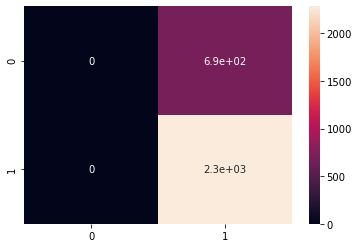

In [35]:
import seaborn as sns
sns.heatmap(cf, annot=True)